# Oscillation

<!-- This notebook will show how to do a transient simulation with given scheduling results. -->

In [1]:
import andes

import matplotlib.pyplot as plt
import scienceplots

In [2]:
!andes misc --version

Python  3.12.0
andes   1.9.3
numpy   1.26.0
kvxopt  1.3.2.1
sympy   1.13.3
scipy   1.13.1
pandas  2.2.2
numba   0.60.0


In [3]:
%matplotlib inline

In [4]:
andes.config_logger(stream_level=30)

Two-Area System [1]

More info can be found at:
<https://electricgrids.engr.tamu.edu/electric-grid-test-cases/two-area-system/>

1. Prabha Kundur. Power System Stability and Control. McGraw-Hill Professional, 1994.

In [5]:
s1 = andes.load(andes.get_case('kundur/kundur_full.xlsx'),
                setup=False, no_output=True, default_config=True)
s2 = andes.load(andes.get_case('kundur/kundur_full.xlsx'),
                setup=False, no_output=True, default_config=True)

Generating code for 1 models on 12 processes.
Generating code for 1 models on 12 processes.


One tie line is tripped at 2s.

In [6]:
# add two COI to measure the frequency
s1.COI.add(idx='COI_1')
s1.COI.add(idx='COI_2')

s2.COI.add(idx='COI_1')
s2.COI.add(idx='COI_2')

# hard code COI to generators
s1.GENROU.coi.v = ['COI_1'] * 2 + ['COI_2'] * 2
s2.GENROU.coi.v = ['COI_1'] * 2 + ['COI_2'] * 2

# turn off the line trip
s2.Toggle.set(src='u', attr='v', idx=1, value=0)
# add a Toggle to trip generator
s2.Toggle.add(idx=2, model='GENROU', dev=3, t=1)

s1.setup()
s2.setup()


True

In [7]:
for ss in [s1, s2]:
    ss.TDS.config.tf = 30
    ss.TDS.config.no_tqdm = True
    ss.TDS.config.criteria = 0

    ss.PFlow.run()

    _ = ss.TDS.init()

In [8]:
s1.TDS.run()

s2.TDS.run()

<Toggle 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
<Toggle 2>: GENROU.3 status changed to 0 at t=1.0 sec.


True

There are damped 0.59 Hz oscillation after the disturbance in both cases.

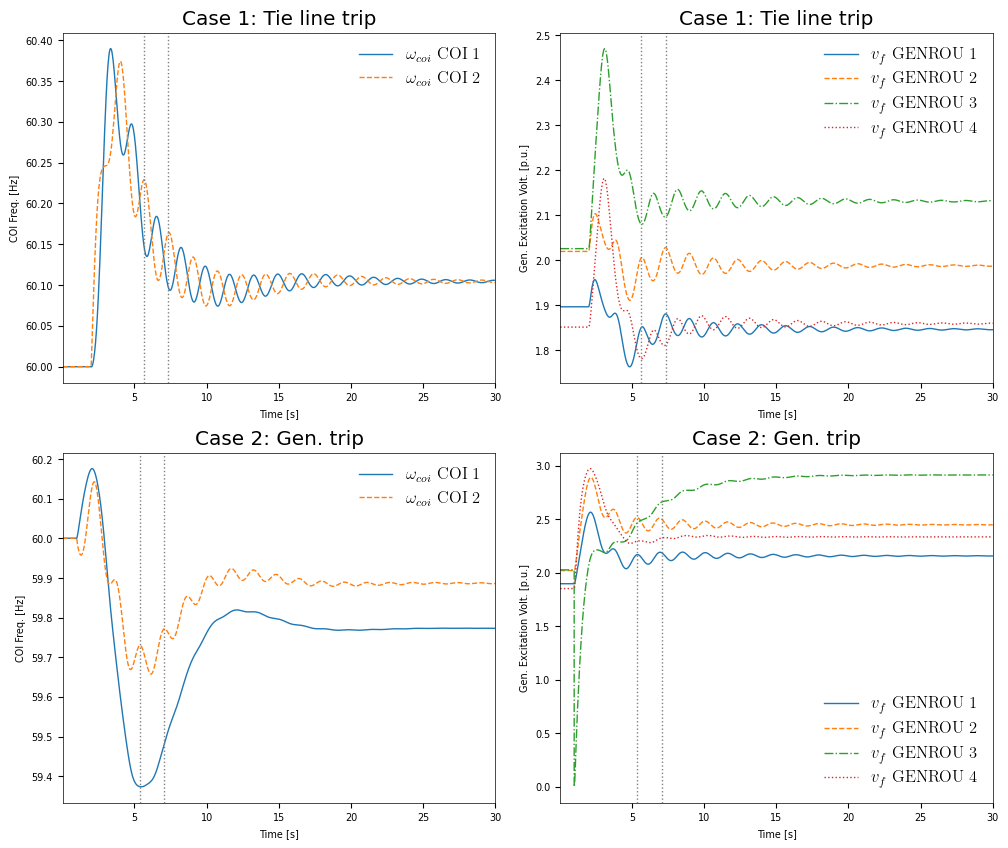

In [9]:
plt.style.use(['default', 'nature'])
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.15)

_ = s1.TDS.plt.plot(s1.COI.omega,
                    ytimes=s1.config.freq,
                    grid=False, show=False,
                    vline=[5.65, 7.35],
                    fig=fig, ax=ax[0, 0],
                    ylabel='COI Freq. [Hz]',
                    title='Case 1: Tie line trip')
_ = s1.TDS.plt.plot(s1.GENROU.vf,
                    grid=False, show=False,
                    vline=[5.65, 7.35],
                    fig=fig, ax=ax[0, 1],
                    ylabel='Gen. Excitation Volt. [p.u.]',
                    title='Case 1: Tie line trip',)

_ = s2.TDS.plt.plot(s2.COI.omega,
                    ytimes=s2.config.freq,
                    grid=False, show=False,
                    vline=[5.35, 7.05],
                    fig=fig, ax=ax[1, 0],
                    ylabel='COI Freq. [Hz]',
                    title='Case 2: Gen. trip')
_ = s2.TDS.plt.plot(s2.GENROU.vf,
                    grid=False, show=False,
                    vline=[5.35, 7.05],
                    fig=fig, ax=ax[1, 1],
                    ylabel='Gen. Excitation Volt. [p.u.]',
                    title='Case 2: Gen. trip',)